# Предиктивная аналитика оттока сотрудников

У проекта есть даже свой лендинг на сайте Академии Лад: https://predictive-analytics.lad-academy.ru/

Коротко о задаче:
- В рассматриваемом отделе высокая текучесть кадров в течение года
- Сотрудники во время работы оставляют электронные следы своей активности
  - Активность на рабочей почте, как на основном таск менеджере в отделе
  - Больничные, отпуска, дополнительные обучения и повышения квалификации
  - Для офисных людей также ведется регистрация их времени на работе
- Также есть личная информация по датам изменений окладов, должностей, приема на работу, возрасту и полу
- Необходимо создать вспомогательную систему, позволяющую в автоматическом режиме предоставлять руководителю отдела и HR-менеджеру информацию о демотивированных или собирающихся к уходу лицам для принятия мер по повышению мотивации или удержанию сотрудника в компании



Поскольку изначальные отчеты (данные) по сотрудникам формировались в различных средах, этап инженерии данных, а именно форматирование, удаление выбросов, замена пропущенных значений, проходил в асинхронном режиме для каждого отчета (категории) отдельно. И только потом в результате преобразований, все эти данные сливались в единый датасет. (В кратце: был основной список работников в каждом месяце, и на него нанизывались остальные их показатели за три смежных месяца левым джойном (pd.merge), как показатели в рамках скользящего окна, а потом все окно двигалось на месяц вперед и повторялось заново; результаты нового окна уже присоединялись к датасету как новые строчки обычной конкатенацией(pd.concat)).

Так вот, поскольку я не могу шарить код процессов, далее используется уже отформатированный датасет по некоторым критериям в роде обработки пропущенных значений, выбросов (хотя с физической точки зрения их обработать полностью не получилось, т.к. не могли по некоторым сотрудникам предоставить более подробную информацию). В общем, данные по таким критериям для журнала дз взяты на глаз...

## 1. Загрузка библиотек и данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import numpy as np

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def schedule_selection(row):
    x = sum([row[f'{k+1}м Удаленная работа'] for k in range(3)])
    
    if x == 3:
        return 1
    elif x == 0:
        return 0
    else:
        return -1

In [3]:
# Загрузим датасет
data = pd.read_csv("learning_dataset.csv")

# Cразу же закодируем бинарным способом пол сотрудников, чтобы в будущем работать только с числовыми параметрами.
data["Пол"] = data["Пол"].apply(lambda x: 0 if x == "Женский" else 1)

# Так же выделим отдельный признак отвечающий за факт удаленной работы. В столбце "Вариант работы": 0 - офис, 1 - удаленка, -1 - смешанный.
data['Вариант работы'] = data.apply(lambda row: schedule_selection(row), axis=1)

# Также при создании этого датасета применялся сразу же и oversampling метод для "уволенных" строчек, как метод позволяющий сбалансировать отстающий класс.
# Чтобы это пока не влияло на графики и статистику, удаляю размноженные строчки.
data.drop_duplicates(inplace=True)

data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 2543 entries, 0 to 2749
Data columns (total 74 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Сотрудник                                                2543 non-null   object 
 1   Пол                                                      2543 non-null   int64  
 2   Возраст                                                  2543 non-null   float64
 3   Отработал дней                                           2543 non-null   float64
 4   Разница_изменение_должности                              2543 non-null   float64
 5   Разница_изменение_оклада                                 2543 non-null   float64
 6   1м Отправленные письма                                   2543 non-null   float64
 7   1м Отредактированные файлы                               2543 non-null   float64
 8   1м Активные дни (Google)         

,Сотрудник,Пол,Возраст,Отработал дней,Разница_изменение_должности,Разница_изменение_оклада,1м Отправленные письма,1м Отредактированные файлы,1м Активные дни (Google),1м Дневное среднее (Отправленные письма),1м Дневное среднее (Отредактированные файлы),1м Факт обучения,1м Дней БЛ,1м Количество отпусков (Основной),1м Количество дней (Основной),1м Количество отпусков (За свой счет),1м Количество дней (За свой счет),1м Всего часов (ACMS),1м Дней на работе (ACMS),1м Среднее время на работе (ACMS),1м Переработка,1м Удаленная работа,2м Отправленные письма,2м Отредактированные файлы,2м Активные дни (Google),2м Дневное среднее (Отправленные письма),2м Дневное среднее (Отредактированные файлы),2м Факт обучения,2м Дней БЛ,2м Количество отпусков (Основной),2м Количество дней (Основной),2м Количество отпусков (За свой счет),2м Количество дней (За свой счет),2м Всего часов (ACMS),2м Дней на работе (ACMS),2м Среднее время на работе (ACMS),2м Переработка,2м Удаленная работа,3м Отправленные письма,3м Отредактированные файлы,3м Активные дни (Google),3м Дневное среднее (Отправленные письма),3м Дневное среднее (Отредактированные файлы),3м Факт обучения,3м Дней БЛ,3м Количество отпусков (Основной),3м Количество дней (Основной),3м Количество отпусков (За свой счет),3м Количество дней (За свой счет),3м Всего часов (ACMS),3м Дней на работе (ACMS),3м Среднее время на работе (ACMS),3м Переработка,3м Удаленная работа,Уволен,Отработал месяцев,Изменение должности (в месяцах),Изменение оклада (в месяцах),Количество отпусков (Основные отпуска),Количество дней (Основные отпуска),Количество отпусков (Отпуска за свой счет),Количество дней (Отпуска за свой счет),Факты обучения,Больничных дней,Средняя переработка за три месяца,2-1 Отн. изменение активности (Отправленные письма),2-1 Отн. изменение активности (Отредактированные файлы),2-1 Отн. изменение активности (Время на работе),2-1 Отн. изменение активности (Активных дней),3-2 Отн. изменение активности (Отправленные письма),3-2 Отн. изменение активности (Отредактированные файлы),3-2 Отн. изменение активности (Время на работе),3-2 Отн. изменение активности (Активных дней),Вариант работы
0,6cb16d5872ddf3e6d66368f3bca42b250b5a403eb2814fc1b1c8c0bf1a0861b6,1,29.00,539.00,-1.00,539.00,155.00,3.00,24,6.46,0.12,0.00,0.00,0.00,0.00,0.00,0.00,88.45,13.00,6.80,0.00,0,279.00,1.00,23.00,12.13,0.04,0.00,0.00,1.00,7.00,0.00,0.00,85.79,13.00,6.60,0.00,0.00,407.00,0.00,25.00,16.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,108.51,18.00,6.03,0.00,0.00,0,17.97,-1.00,17.97,1.00,7.00,0.00,0.00,0.00,0.00,0.00,0.88,-0.65,-0.03,-0.04,0.34,-1.00,-0.09,0.09,0
1,b20d006cc40d753441ac14aa4d6e1b17ee04408c68467bcbd3e33d5ba4a29940,0,21.00,358.00,-1.00,-1.00,184.00,26.00,23,8.00,1.13,0.00,0.00,0.00,0.00,0.00,0.00,83.58,14.00,5.97,0.00,0,294.00,13.00,26.00,11.31,0.50,0.00,0.00,0.00,0.00,0.00,0.00,146.22,19.00,7.70,0.00,0.00,114.00,14.00,22.00,5.18,0.64,0.00,0.00,1.00,7.00,0.00,0.00,102.11,13.00,7.85,0.00,0.00,0,11.93,-1.00,-1.00,1.00,7.00,0.00,0.00,0.00,0.00,0.00,0.41,-0.56,0.29,0.13,-0.54,0.27,0.02,-0.15,0
2,6362266aa19a113d3865682f4d710db06e8bbfaa2c6340878d0758428b196d2e,1,47.00,288.00,80.00,64.00,38.00,25.00,18,2.11,1.39,0.00,0.00,1.00,5.00,1.00,1.00,95.25,18.00,5.29,0.00,0,10.00,112.00,8.00,1.25,14.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,11.00,1.00,9.00,1.22,0.11,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1,9.60,2.67,2.13,2.00,6.00,3.00,3.00,0.00,0.00,0.00,-0.41,9.08,-1.00,-0.56,-0.02,-0.99,0.00,0.12,-1
3,4a846608589e281e6d8cd362d2b555f5a23370aff0b7f0797c4d69e3a83d6099,1,38.00,2353.00,305.00,64.00,10.00,8.00,9,1.11,0.89,0.00,8.00,1.00,5.00,2.00,2.00,21.37,8.00,2.67,0.00,0,2.00,13.00,14.00,0.14,0.93,0.00,0.00,0.00,0.00,0.00,0.00,21.19,6.00,3.53,0.00,0.00,7.00,19.00,16.00,0.44,1.19,0.00,0.00,0.00,0.00,1.00,1.00,45.22,16.00,2.83,0.00,0.00,0,78.43,10.17,2.13,1.00,5.00,3.00,3.00,0.00,8.00,0.00,-0.87,0.04,0.32,0.56,2.06,0.28,-0.20,0.14,0
4,9eea0d4b6cf2177706b0d336b831ee70ecf12ec65e5f95dcde7d0c103022fe95,1,37.00,532.00,-1.00

In [4]:
# Также неплохо помимо проверки null-значений и типов данных, посмотреть за общей, но расширенной информацией по данным в столбцах.
data.describe()

,Пол,Возраст,Отработал дней,Разница_изменение_должности,Разница_изменение_оклада,1м Отправленные письма,1м Отредактированные файлы,1м Активные дни (Google),1м Дневное среднее (Отправленные письма),1м Дневное среднее (Отредактированные файлы),1м Факт обучения,1м Дней БЛ,1м Количество отпусков (Основной),1м Количество дней (Основной),1м Количество отпусков (За свой счет),1м Количество дней (За свой счет),1м Всего часов (ACMS),1м Дней на работе (ACMS),1м Среднее время на работе (ACMS),1м Переработка,1м Удаленная работа,2м Отправленные письма,2м Отредактированные файлы,2м Активные дни (Google),2м Дневное среднее (Отправленные письма),2м Дневное среднее (Отредактированные файлы),2м Факт обучения,2м Дней БЛ,2м Количество отпусков (Основной),2м Количество дней (Основной),2м Количество отпусков (За свой счет),2м Количество дней (За свой счет),2м Всего часов (ACMS),2м Дней на работе (ACMS),2м Среднее время на работе (ACMS),2м Переработка,2м Удаленная работа,3м Отправленные письма,3м Отредактированные файлы,3м Активные дни (Google),3м Дневное среднее (Отправленные письма),3м Дневное среднее (Отредактированные файлы),3м Факт обучения,3м Дней БЛ,3м Количество отпусков (Основной),3м Количество дней (Основной),3м Количество отпусков (За свой счет),3м Количество дней (За свой счет),3м Всего часов (ACMS),3м Дней на работе (ACMS),3м Среднее время на работе (ACMS),3м Переработка,3м Удаленная работа,Уволен,Отработал месяцев,Изменение должности (в месяцах),Изменение оклада (в месяцах),Количество отпусков (Основные отпуска),Количество дней (Основные отпуска),Количество отпусков (Отпуска за свой счет),Количество дней (Отпуска за свой счет),Факты обучения,Больничных дней,Средняя переработка за три месяца,2-1 Отн. изменение активности (Отправленные письма),2-1 Отн. изменение активности (Отредактированные файлы),2-1 Отн. изменение активности (Время на работе),2-1 Отн. изменение активности (Активных дней),3-2 Отн. изменение активности (Отправленные письма),3-2 Отн. изменение активности (Отредактированные файлы),3-2 Отн. изменение активности (Время на работе),3-2 Отн. изменение активности (Активных дней),Вариант работы
count,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00,2543.00
mean,0.35,33.63,1769.99,308.42,479.78,128.09,18.42,15.58,5.73,0.81,0.03,0.50,0.27,2.14,0.37,0.69,49.95,7.94,3.38,0.08,0.44,129.44,18.60,15.76,5.77,0.82,0.02,0.51,0.26,2.09,0.38,0.67,48.78,7.82,3.32,0.08,0.44,128.52,18.88,15.73,5.75,0.84,0.02,0.48,0.26,2.04,0.38,0.64,47.46,7.64,3.26,0.07,0.45,0.02,59.00,9.77,15.58,0.80,6.27,1.13,2.01,0.07,1.49,0.06,0.08,-0.07,0.81,0.07,0.06,-0.07,0.76,0.03,0.34
std,0.48,8.45,1474.90,533.65,1051.06,153.73,57.63,9.38,6.14,2.82,0.18,2.16,0.48,4.48,0.78,2.36,58.18,8.24,3.42,0.30,0.50,151.19,57.94,9.32,6.04,2.83,0.15,2.17,0.48,4.47,0.79,2.21,57.24,8.17,3.40,0.29,0.50,148.35,58.12,9.28,5.96,2.84,0.14,2.09,0.48,4.43,0.77,2.03,56.41,8.07,3.39,0.28,0.50,0.14,49.16,18.09,35.23,0.96,8.86,1.73,5.42,0.29,3.86,0.26,0.71,1.32,17.63,0.66,0.60,1.33,17.27,0.48,0.60
min,0.00,19.00,61.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.03,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-1.00
25%,0.00,28.00,466.50,-1.00,-1.00,9.00,0.00,7.00,1.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

## 2. Корреляционный анализ.

Проведём корреляционный анализ несколькими способами, а именно стандартной линейной корреляцией Пирсона, а также посредством библиотеки phik, реализующей практическую (не только линейную) корреляцию величины посредством таблиц сопряженности Пирсона.

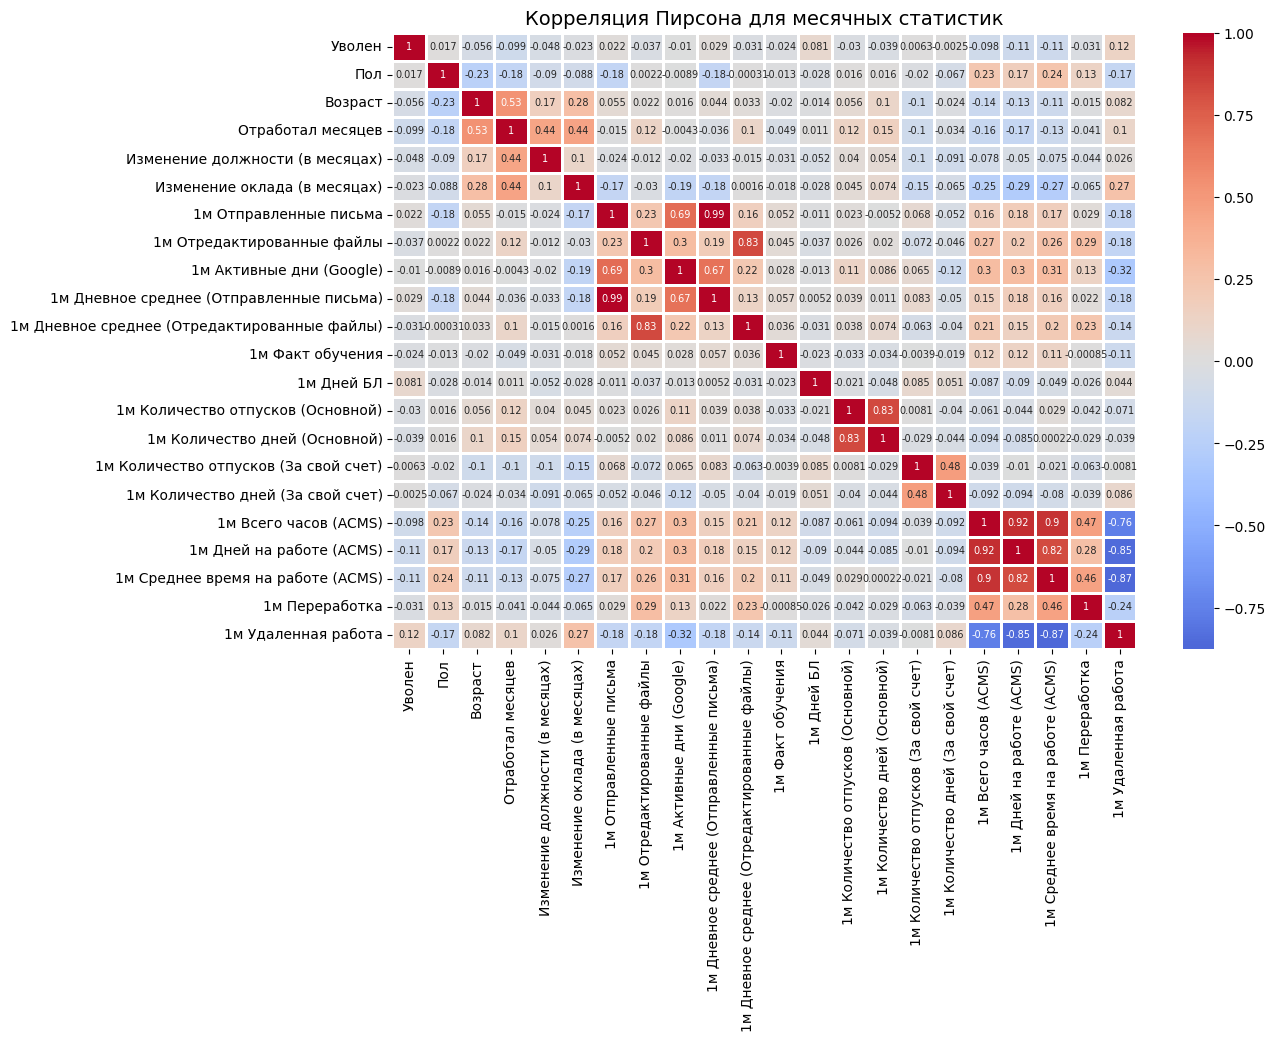

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(data.iloc[:, np.concatenate(([54, 1, 2, 55, 56, 57], np.arange(6, 22)))].corr(), cmap='coolwarm', center=0, annot=True, annot_kws={'size': 7}, linewidths=.8)
plt.title('Корреляция Пирсона для месячных статистик', fontsize=14)
plt.xticks(rotation=90)
plt.show()

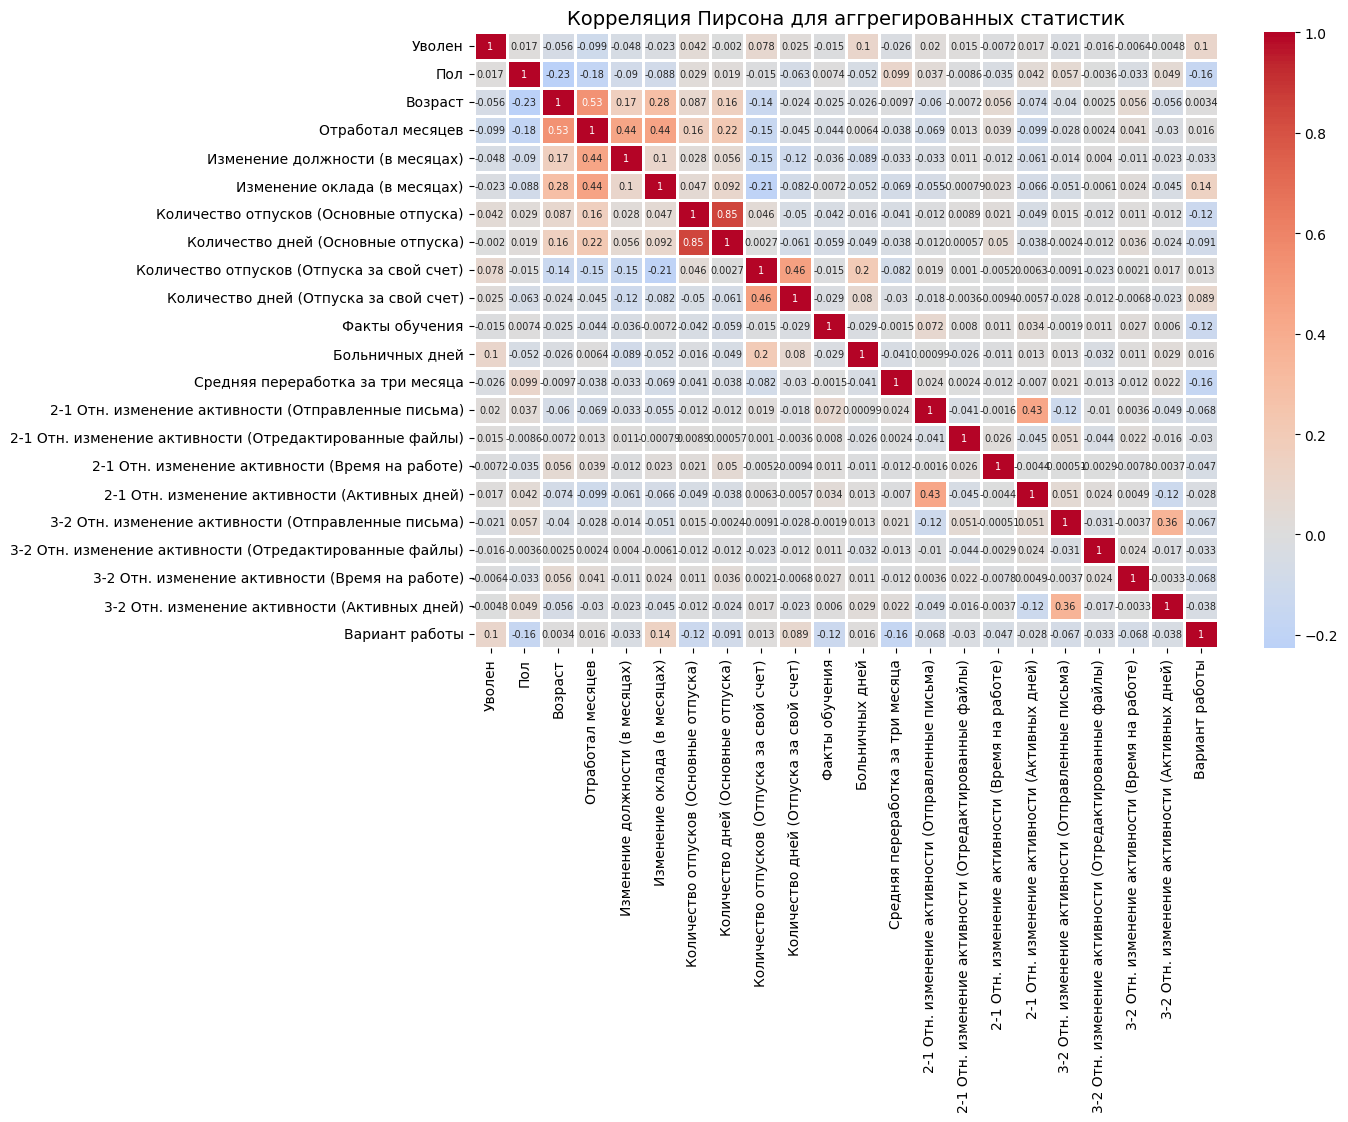

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(data.iloc[:, np.concatenate(([54, 1, 2], np.arange(55, 74)))].corr(), cmap='coolwarm', center=0, annot=True, annot_kws={'size': 7}, linewidths=.8)
plt.title('Корреляция Пирсона для аггрегированных статистик', fontsize=14)
plt.xticks(rotation=90)
plt.show()

Дополнительно рассчитаем корреляцию через библиотеку phik. Такая корреляция способна отслеживать не только линейные зависимости.

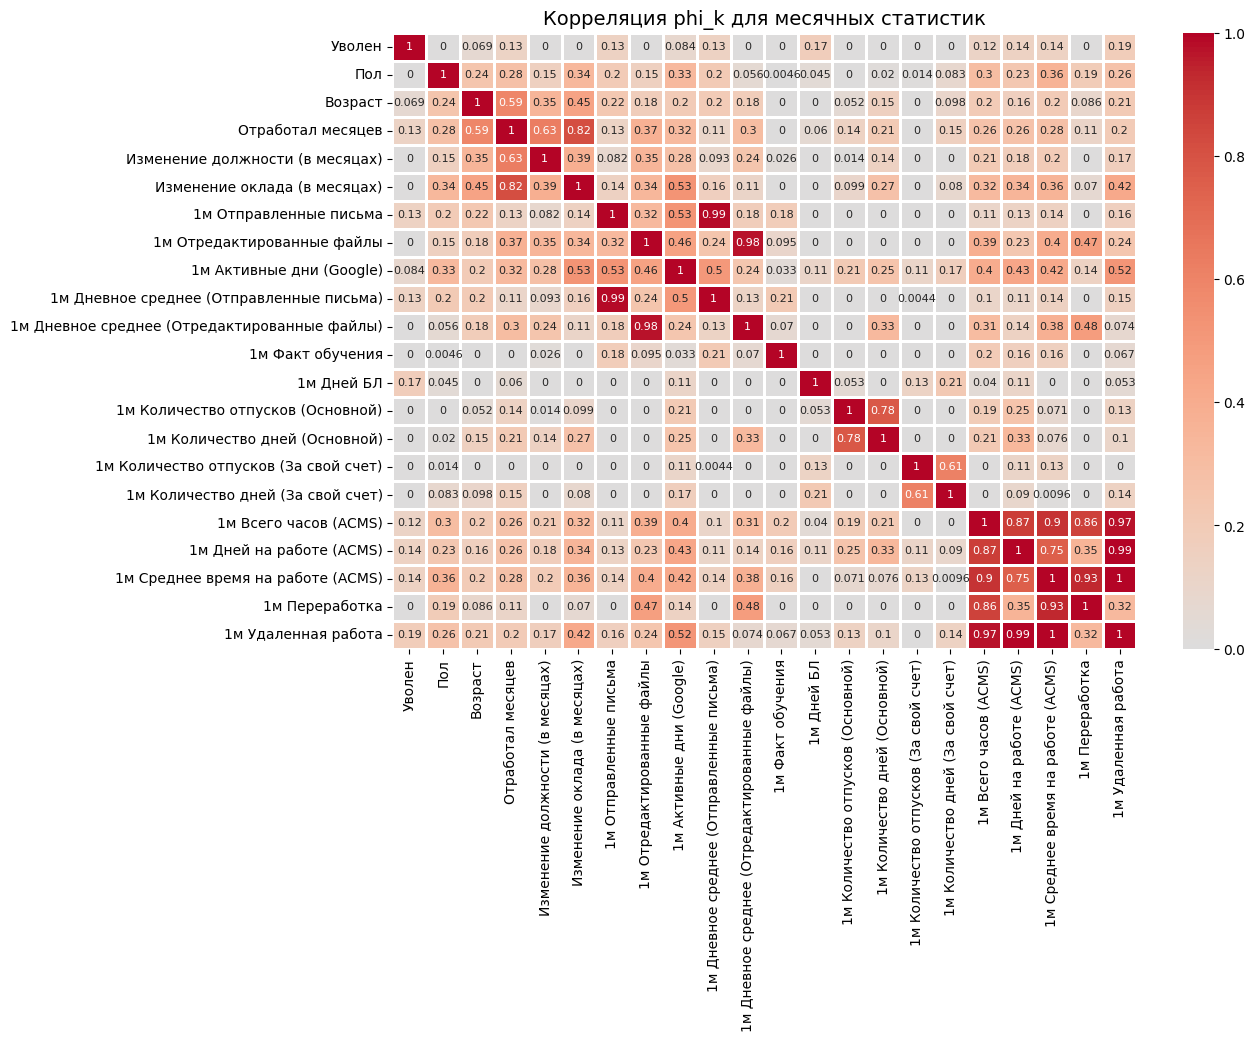

In [7]:
# Расчёт корреляции phi_k
columns = data.columns.to_list()

plt.figure(figsize=(12,8))
sns.heatmap(data.iloc[:, np.concatenate(([54, 1, 2, 55, 56, 57], np.arange(6, 22)))].phik_matrix(interval_cols=columns),
            cmap='coolwarm', center=0, annot=True, annot_kws = {'size': 8}, linewidths=.8)
plt.title('Корреляция phi_k для месячных статистик', fontsize=14)
plt.show()

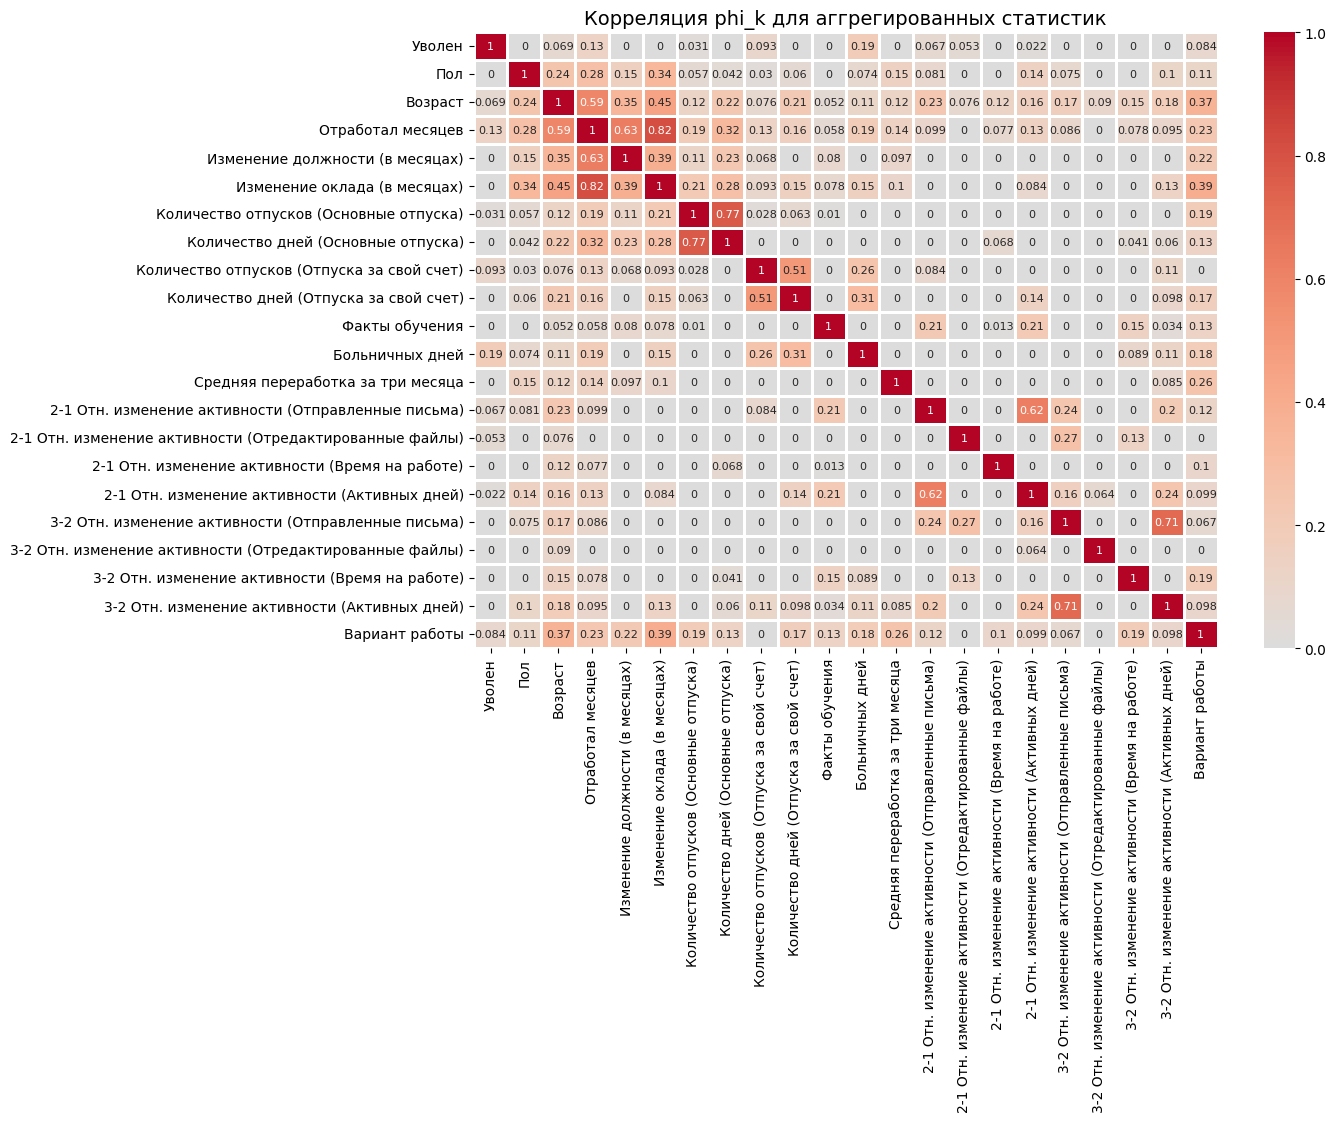

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(data.iloc[:, np.concatenate(([54, 1, 2], np.arange(55, 74)))].phik_matrix(interval_cols=columns),
            cmap='coolwarm', center=0, annot=True, annot_kws = {'size': 8}, linewidths=.8)
plt.title('Корреляция phi_k для аггрегированных статистик', fontsize=14)
plt.xticks(rotation=90)
plt.show()

## 3. Изучение признаков в совокупности и в разрезе оттока, графическая визуализация.

In [9]:
data['Уволен'].value_counts()

Уволен
0    2491
1      52
Name: count, dtype: int64

### 3.1. Половозрастное распределение сотрудников компании в общей совокупности и по увольнению.

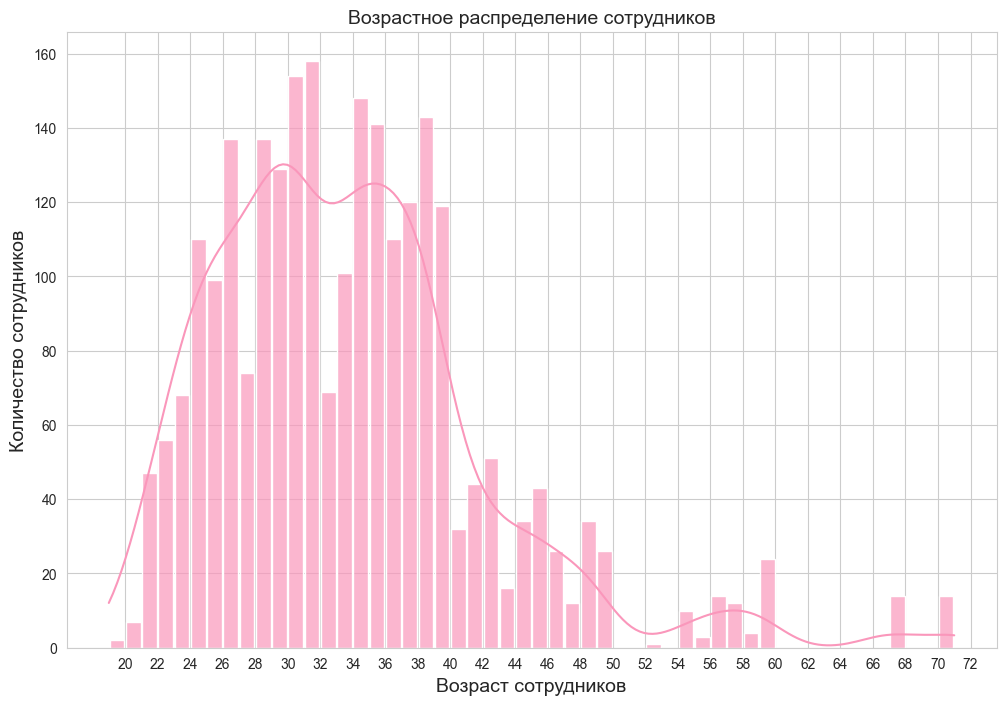

In [10]:
# График возрастного распределения сотрудников
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.histplot(x='Возраст', data=data, color='#fa97BB', common_norm=False, alpha = 0.7, bins=52, kde=True, shrink=.9).set_xticks(range(20,73,2))
plt.title('Возрастное распределение сотрудников', fontsize=14)
plt.ylabel('Количество сотрудников', fontsize=14)
plt.xlabel('Возраст сотрудников', fontsize=14)
plt.show()

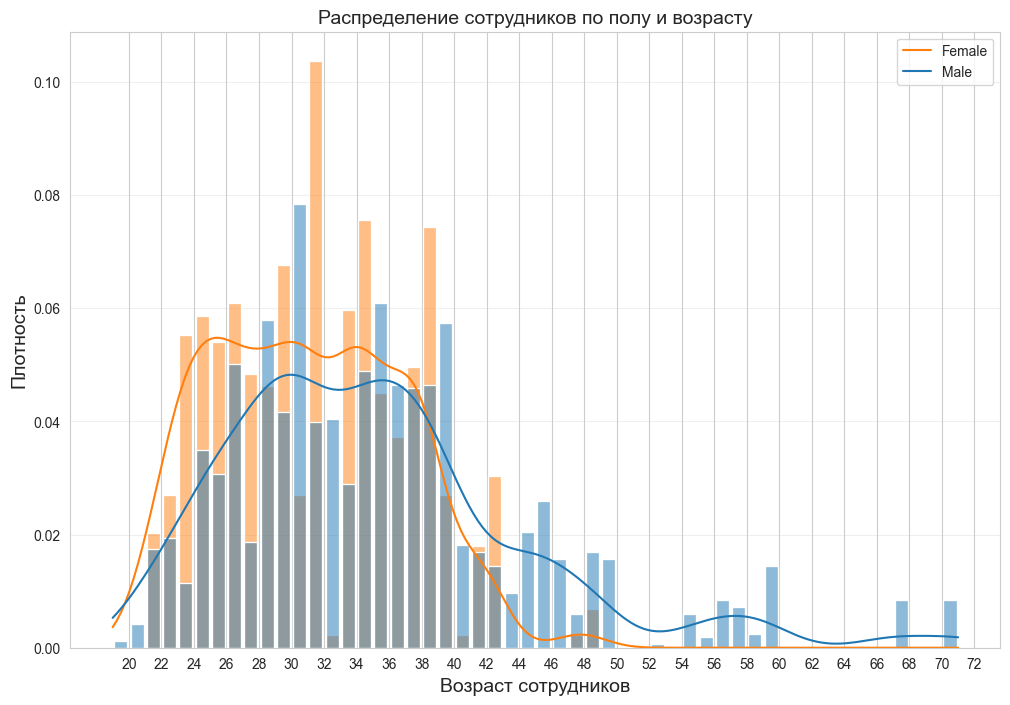

In [11]:
# График половозрастного распределения сотрудников
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

sns.histplot(x='Возраст', hue='Пол', data=data, stat="density", common_norm=False,
             alpha = 0.5, bins=52, kde=True, shrink=.8).set_xticks(range(20,73,2))

plt.legend(labels=['Female', 'Male'])
plt.grid(visible=True, alpha=0.3, axis='y')
plt.title('Распределение сотрудников по полу и возрасту', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Возраст сотрудников', fontsize=14)
plt.show()

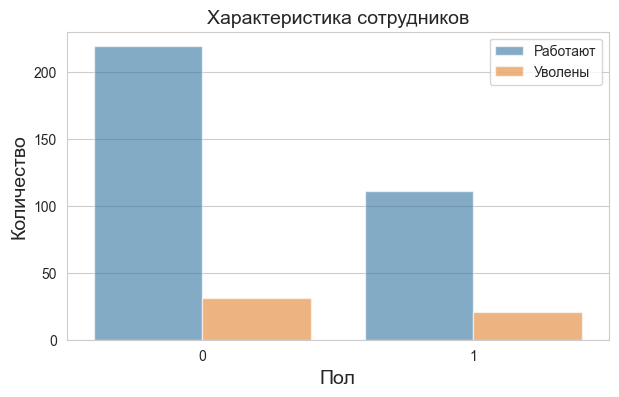

In [12]:
# Формирование таблицы полового распределения сотрудников в разрезе "работает - уволен"
temp = data.drop_duplicates(subset=['Сотрудник', 'Возраст', 'Пол']).loc[:, ['Сотрудник', 'Возраст', 'Пол']]
tmp = data.drop_duplicates(subset=['Сотрудник', 'Уволен'])
temp = pd.merge(temp, tmp[tmp['Уволен'] == 1], how='left').fillna(0)

# График количества уволившихся сотрудников в разрезе пола                                     
plt.figure(figsize=(7, 4))
sns.countplot(data=temp, x='Пол', hue="Уволен", alpha=0.6)
plt.legend(labels=['Работают', 'Уволены'])
plt.title('Характеристика сотрудников', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Пол', fontsize=14)
plt.show()

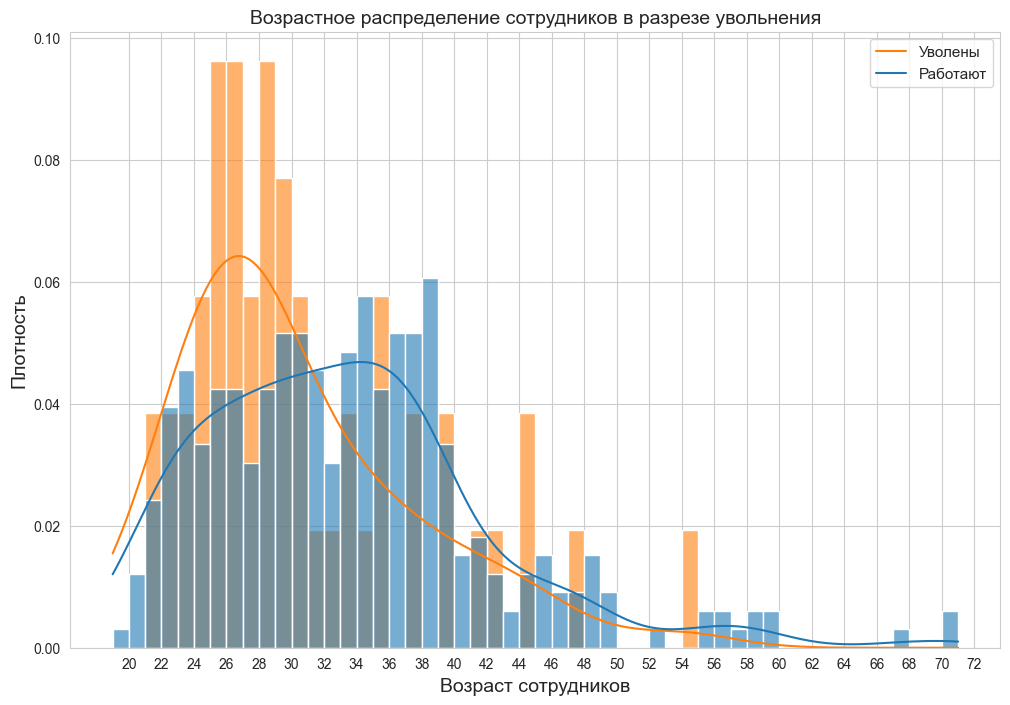

In [13]:
# График возрастного распределения сотрудников в разрезе увольнения
plt.figure(figsize=(12, 8))
sns.histplot(x='Возраст', hue='Уволен', data=temp, stat="density", common_norm=False, alpha = 0.6, bins=52, kde=True).set_xticks(range(20,73,2))
plt.title('Возрастное распределение сотрудников в разрезе увольнения', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Возраст сотрудников', fontsize=14)
plt.legend(title=None, labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

Чаще всего увольняются сотрудники в возрасте 25-30 лет.

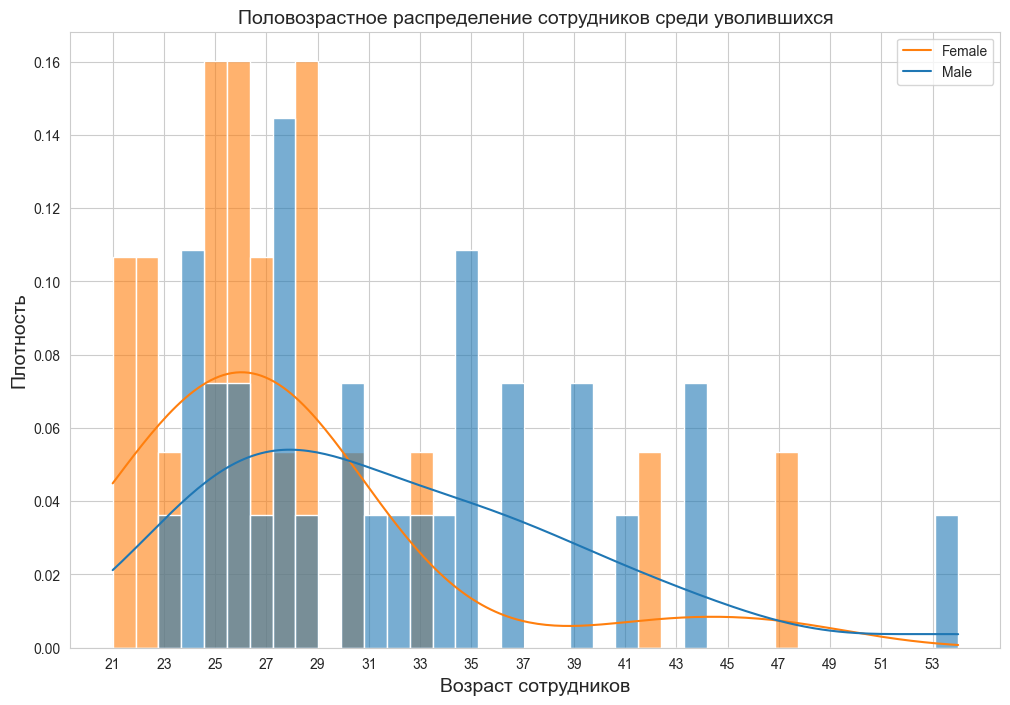

In [14]:
# График половозрастного распределения сотрудников среди уволившихся
plt.figure(figsize=(12, 8))
sns.histplot(x='Возраст', hue='Пол', data=temp.query('Уволен == 1'), stat="density", common_norm=False, alpha=0.6, bins=37,
            kde=True).set_xticks(range(21,55,2))
plt.legend(labels=['Female', 'Male'])
plt.title('Половозрастное распределение сотрудников среди уволившихся', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Возраст сотрудников', fontsize=14)
plt.show()

На графике выше отражено распределение уволившихся сотрудников по полу и возрасту.

### 3.2. Признак трудового стажа работы в компании.

In [15]:
data['Отработал месяцев'].describe()

count   2543.00
mean      59.00
std       49.16
min        2.03
25%       15.55
50%       42.93
75%       93.15
max      161.30
Name: Отработал месяцев, dtype: float64

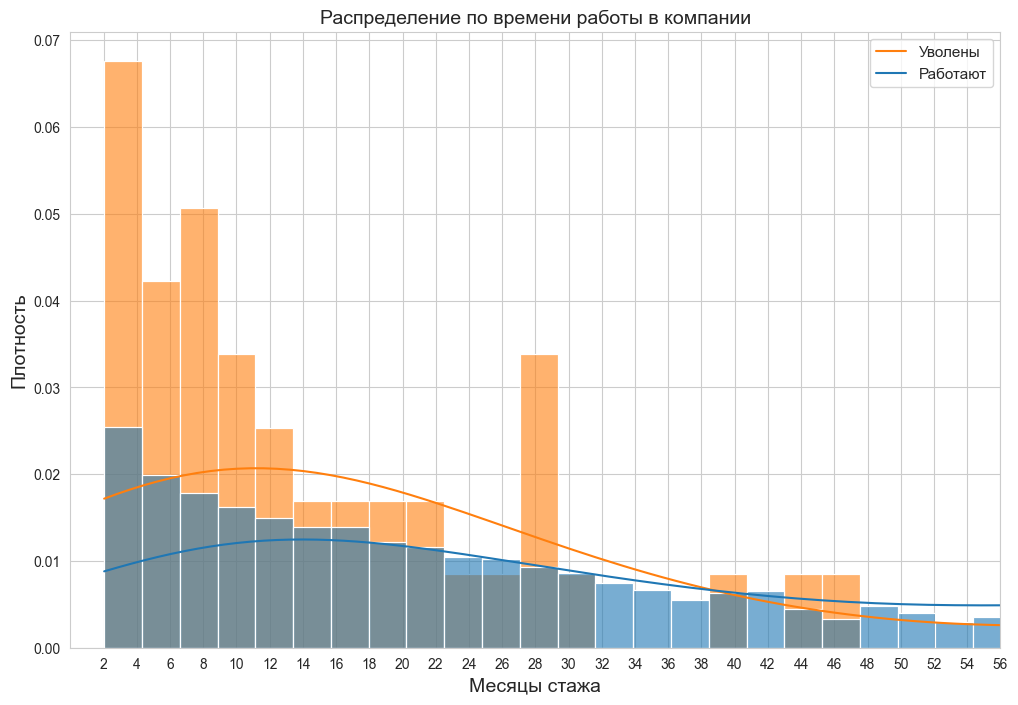

In [16]:
# График распределения дней трудового стража работы в компании в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='Отработал месяцев', hue='Уволен', data=data, stat="density", common_norm=False, alpha=0.6, kde=True, bins=70)
plt.xticks(np.arange(2, 57, 2))
plt.xlim(0, 56)
plt.title('Распределение по времени работы в компании', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Месяцы стажа', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

Наибольшее часто сотрудники увольнялись в течении полугода со дня трудоустройства. Также более часто сотрудники увольнялись в течении первых двух лет работы в компании.

### 3.3. Признак "разница_изменение_должности".

In [17]:
data['Изменение должности (в месяцах)'].describe()

count   2543.00
mean       9.77
std       18.09
min       -1.00
25%       -1.00
50%       -1.00
75%       13.17
max       77.07
Name: Изменение должности (в месяцах), dtype: float64

В данном столбце отображается время с последнего изменения должности, либо если этого не было, то трудоустройства, также под -1 понимается (закодировано), что когда было последнее изменение должности - неизвестно. 

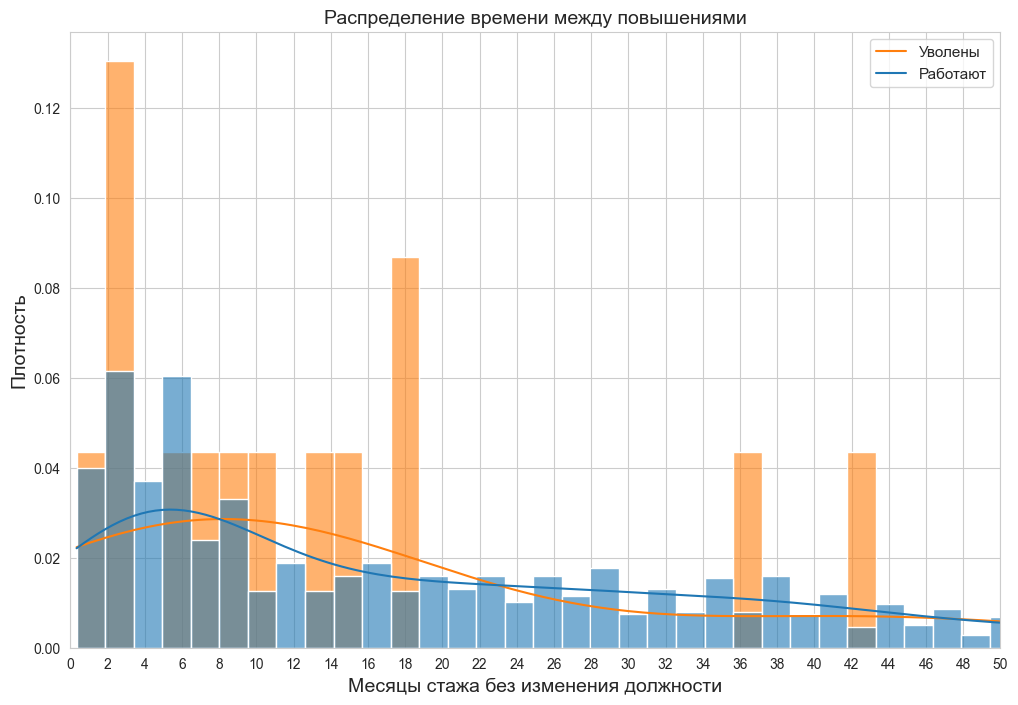

In [19]:
# График распределения разницы изменения должности в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='Изменение должности (в месяцах)', hue='Уволен', data=data[data['Изменение должности (в месяцах)'] > 0],
             stat="density", common_norm=False, alpha=0.6, kde=True, bins=50)
plt.xticks(np.arange(0, 51, 2))
plt.xlim(0, 50)
plt.title('Распределение времени между повышениями', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Месяцы стажа без изменения должности', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

### 3.4. Признак "разница_изменение_оклада".

In [20]:
data['Изменение оклада (в месяцах)'].describe()

count   2543.00
mean      15.58
std       35.23
min       -1.00
25%       -1.00
50%        1.20
75%       13.08
max      161.30
Name: Изменение оклада (в месяцах), dtype: float64

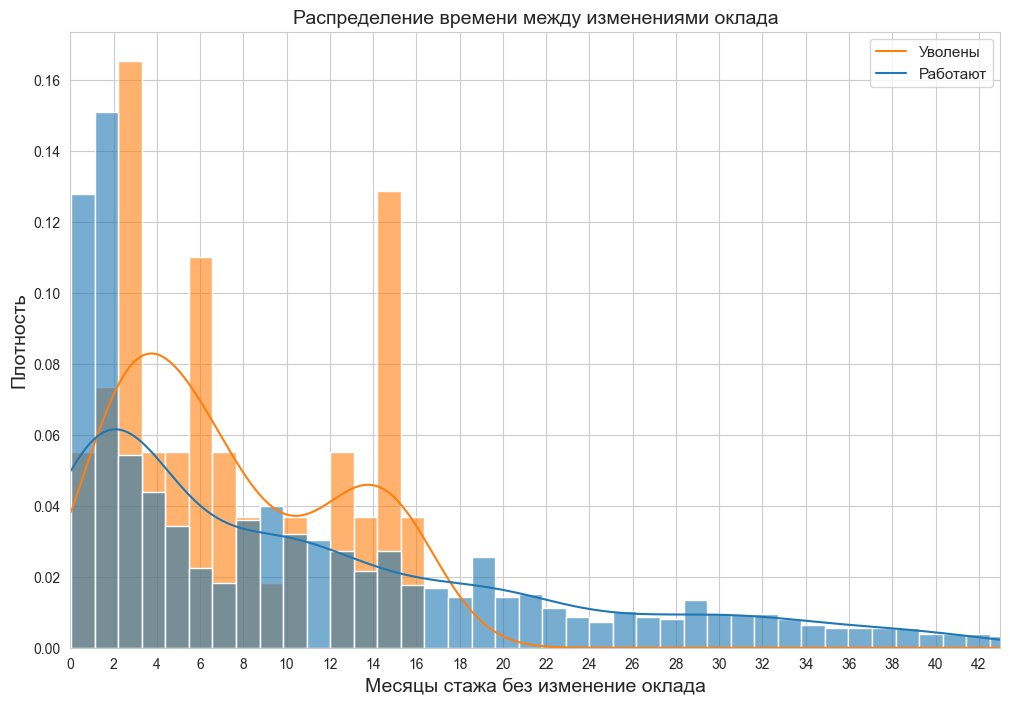

In [21]:
# График распределения разницы изменения оклада сотрудников ???? в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='Изменение оклада (в месяцах)', hue='Уволен', data=data[(data['Изменение оклада (в месяцах)'] > 0) &
                                                                       (data['Изменение оклада (в месяцах)'] < 45)],
             stat="density", common_norm=False, alpha=0.6, kde=True, bins=40)
plt.xticks(np.arange(0, 43, 2))
plt.xlim(0, 43)
plt.title('Распределение времени между изменениями оклада', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Месяцы стажа без изменение оклада', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

### 3.5. Количество отправленных писем.

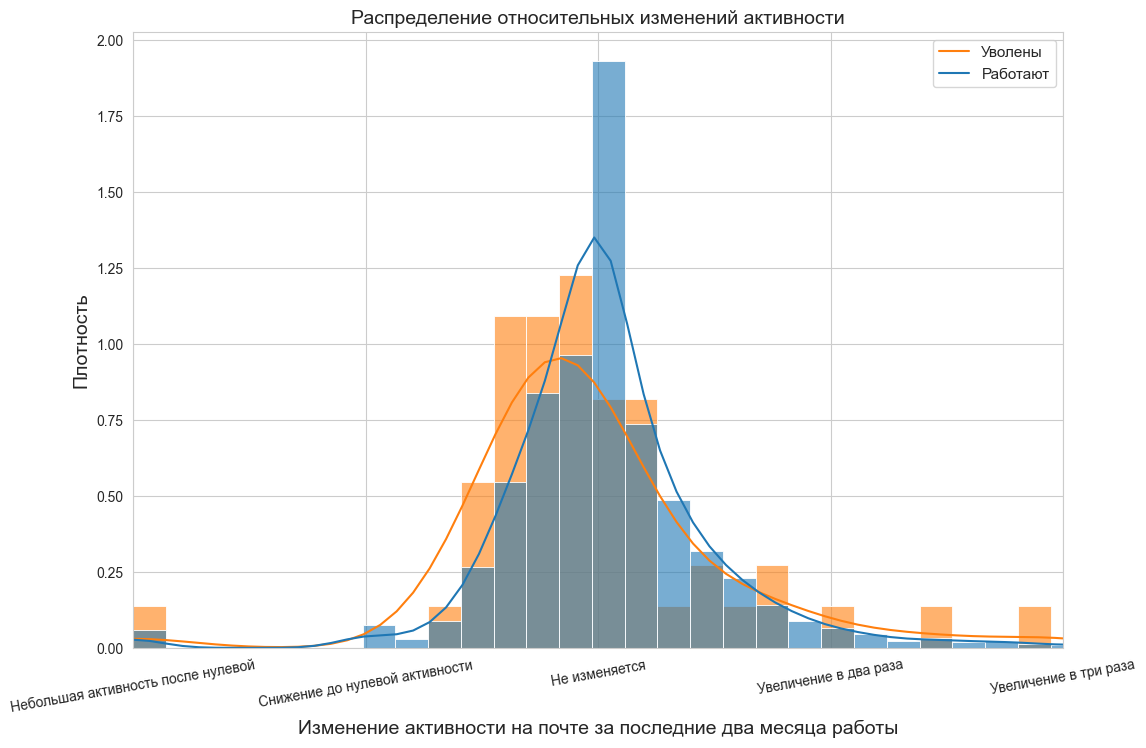

In [22]:
# График распределения количества отправленных писем в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='3-2 Отн. изменение активности (Отправленные письма)', hue='Уволен', data=data[data['3-2 Отн. изменение активности (Отправленные письма)'] < 20],
             stat="density", common_norm=False, alpha=0.6, kde=True, bins=100)
plt.xticks(np.arange(-2, 3, 1), labels=['Небольшая активность после нулевой', 'Снижение до нулевой активности',
                                        'Не изменяется', 'Увеличение в два раза', 'Увеличение в три раза'],
           rotation=10)
plt.xlim(-2, 2)
plt.title('Распределение относительных изменений активности', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Изменение активности на почте за последние два месяца работы', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

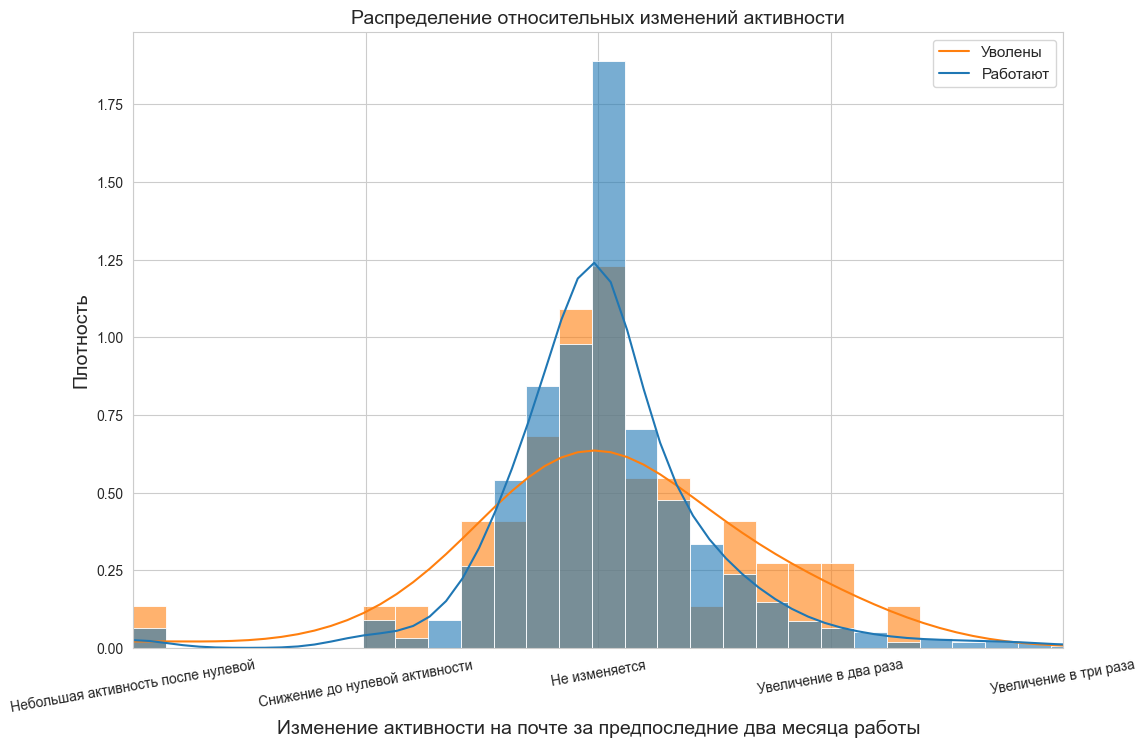

In [23]:
# График распределения количества отправленных писем в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='2-1 Отн. изменение активности (Отправленные письма)', hue='Уволен', data=data[data['2-1 Отн. изменение активности (Отправленные письма)'] < 20],
             stat="density", common_norm=False, alpha = 0.6, kde=True, bins=100)
plt.xticks(np.arange(-2, 3, 1), labels=['Небольшая активность после нулевой', 'Снижение до нулевой активности',
                                        'Не изменяется', 'Увеличение в два раза', 'Увеличение в три раза'],
           rotation=10)
plt.xlim(-2, 2)
plt.title('Распределение относительных изменений активности', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Изменение активности на почте за предпоследние два месяца работы', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

### 3.6. Количество отредактированных файлов.

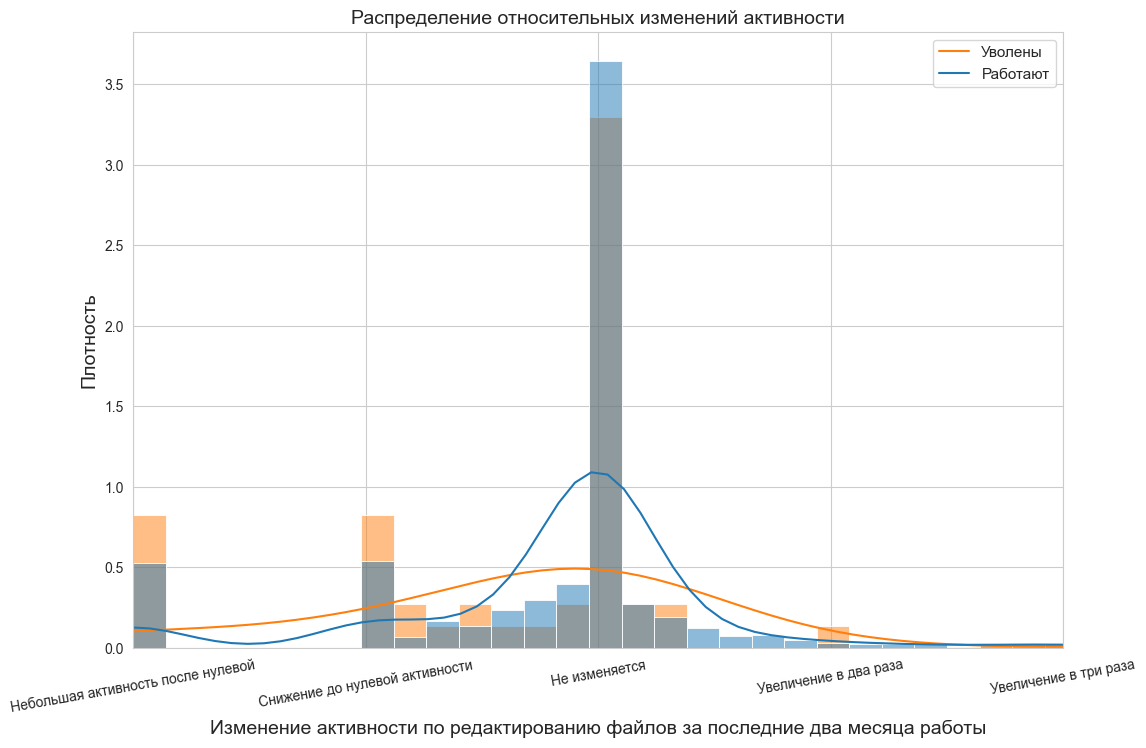

In [24]:
# График распределения количества отправленных писем в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12,8))
sns.histplot(x='3-2 Отн. изменение активности (Отредактированные файлы)', hue='Уволен', data=data[data['3-2 Отн. изменение активности (Отредактированные файлы)'] < 20],
             stat="density", common_norm=False, alpha = 0.5, kde=True, bins=100)
plt.xticks(np.arange(-2, 3, 1), labels=['Небольшая активность после нулевой', 'Снижение до нулевой активности',
                                        'Не изменяется', 'Увеличение в два раза', 'Увеличение в три раза'],
           rotation=10)
plt.xlim(-2, 2)
plt.title('Распределение относительных изменений активности', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Изменение активности по редактированию файлов за последние два месяца работы', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

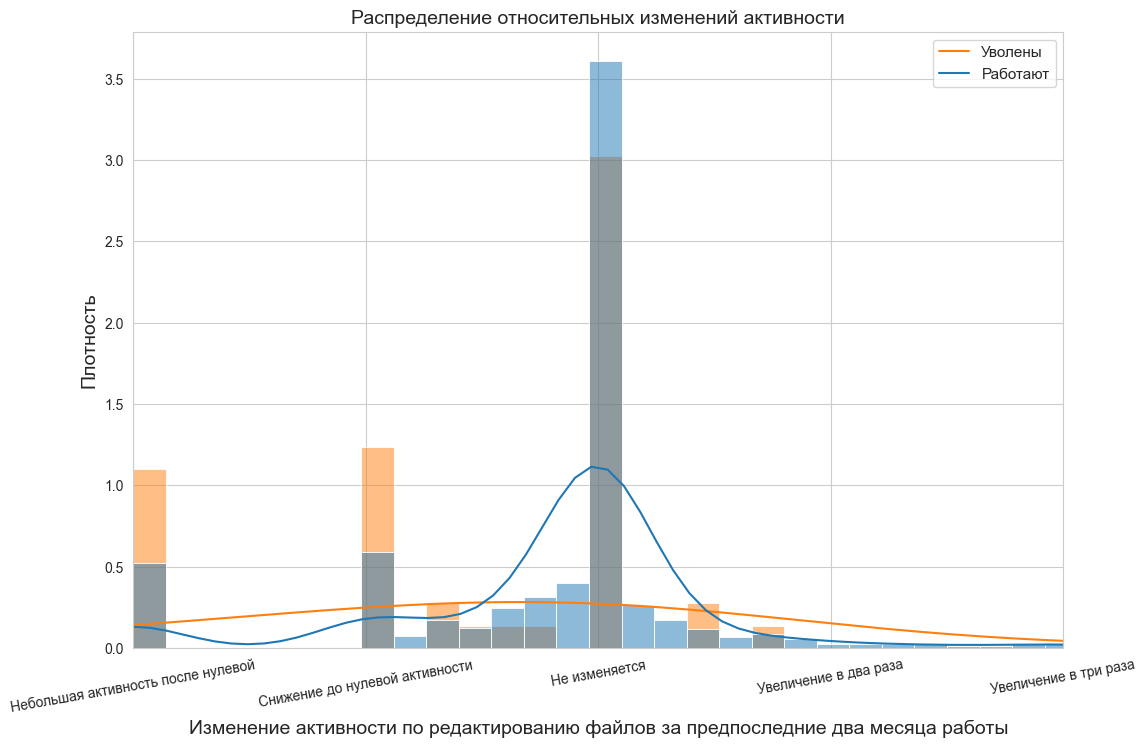

In [25]:
# График распределения количества отправленных писем в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='2-1 Отн. изменение активности (Отредактированные файлы)', hue='Уволен', data=data[data['2-1 Отн. изменение активности (Отредактированные файлы)'] < 20],
             stat="density", common_norm=False, alpha = 0.5, kde=True, bins=100)
plt.xticks(np.arange(-2, 3, 1), labels=['Небольшая активность после нулевой', 'Снижение до нулевой активности',
                                        'Не изменяется', 'Увеличение в два раза', 'Увеличение в три раза'],
           rotation=10)
plt.xlim(-2, 2)
plt.title('Распределение относительных изменений активности', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Изменение активности по редактированию файлов за предпоследние два месяца работы', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

### 3.7. Активные дни (Google).

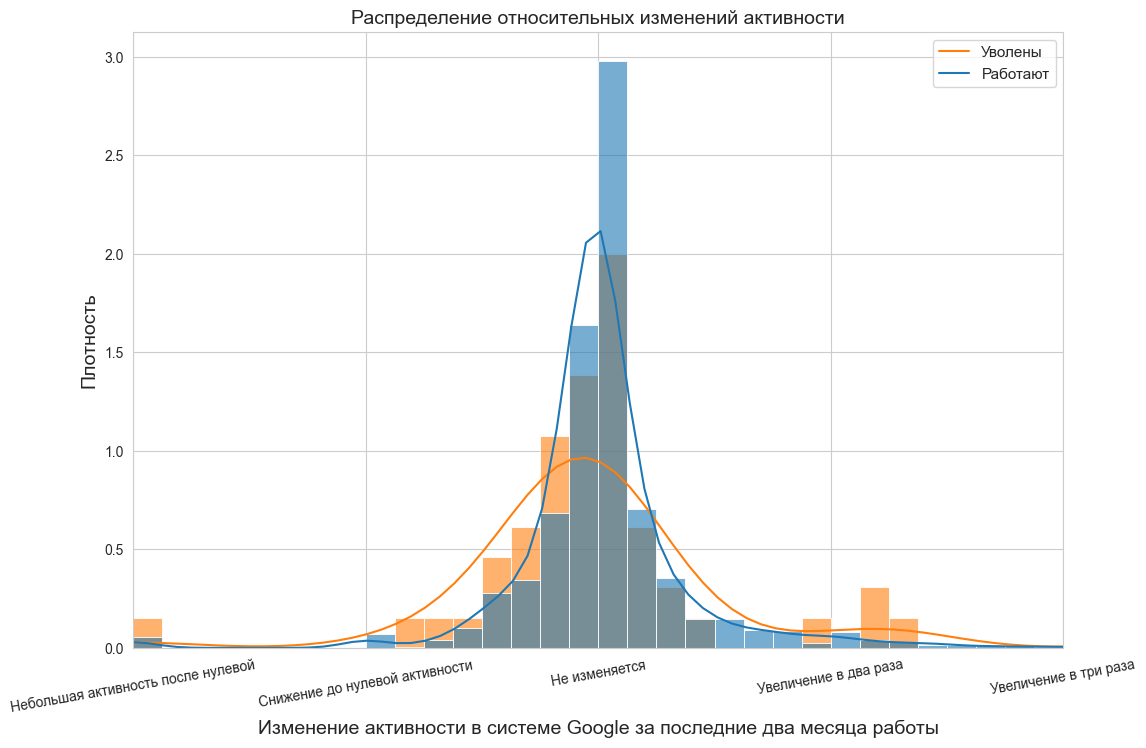

In [26]:
# График распределения количества отправленных писем в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12,8))
sns.histplot(x='3-2 Отн. изменение активности (Активных дней)', hue='Уволен', data=data[data['3-2 Отн. изменение активности (Активных дней)'] < 20],
             stat="density", common_norm=False, alpha=0.6, kde=True, bins=100)
plt.xticks(np.arange(-2, 3, 1), labels=['Небольшая активность после нулевой', 'Снижение до нулевой активности',
                                        'Не изменяется', 'Увеличение в два раза', 'Увеличение в три раза'],
           rotation=10)
plt.xlim(-2, 2)
plt.title('Распределение относительных изменений активности', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Изменение активности в системе Google за последние два месяца работы', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

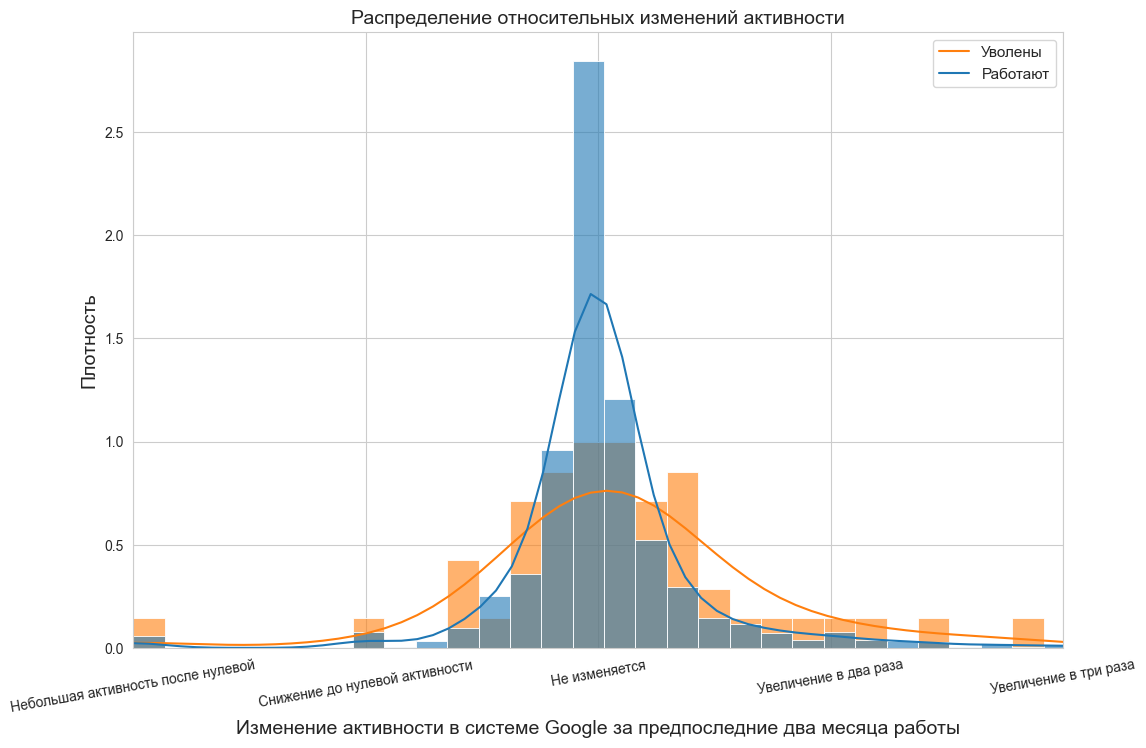

In [27]:
# График распределения количества отправленных писем в разрезе работающих и уволившихся сотрудников
plt.figure(figsize=(12, 8))
sns.histplot(x='2-1 Отн. изменение активности (Активных дней)', hue='Уволен', data=data[data['2-1 Отн. изменение активности (Активных дней)'] < 20],
             stat="density", common_norm=False, alpha=0.6, kde=True, bins=100)
plt.xticks(np.arange(-2, 3, 1), labels=['Небольшая активность после нулевой', 'Снижение до нулевой активности',
                                        'Не изменяется', 'Увеличение в два раза', 'Увеличение в три раза'],
           rotation=10)
plt.xlim(-2, 2)
plt.title('Распределение относительных изменений активности', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.xlabel('Изменение активности в системе Google за предпоследние два месяца работы', fontsize=14)
plt.legend(labels=['Уволены', 'Работают'], fontsize=11)
plt.show()

### 3.8. Отпуска за свой счет.

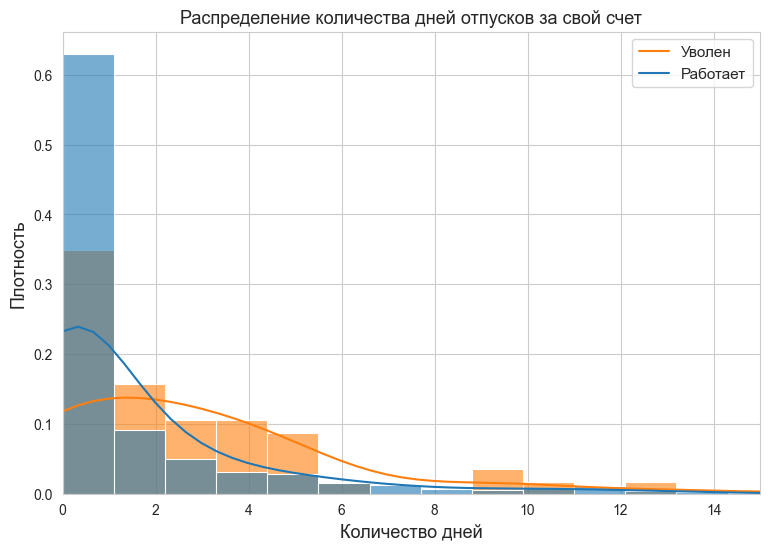

In [29]:
# График распределения количества дней отпуска (за свой счёт) в разрезе работающих и уволившихся сотрудников
# График количества отпусков (основных) в разрезе увольнения
plt.figure(figsize=(9,6))
sns.histplot(x='Количество дней (Отпуска за свой счет)', hue='Уволен', data=data, stat="density",
             common_norm=False, alpha = 0.6, kde=True, bins=60)
plt.legend(labels=['Уволен', 'Работает'], fontsize=11)
plt.title('Распределение количества дней отпусков за свой счет', fontsize=13)
plt.ylabel('Плотность', fontsize=13)
plt.xlabel('Количество дней', fontsize=13)
plt.xlim(0, 15)
plt.show()

### 3.9. Удалённая работа.

In [30]:
data['Вариант работы'].value_counts()

Вариант работы
 0    1326
 1    1038
-1     179
Name: count, dtype: int64

На удалённой работе находятся 65% сотрудников.

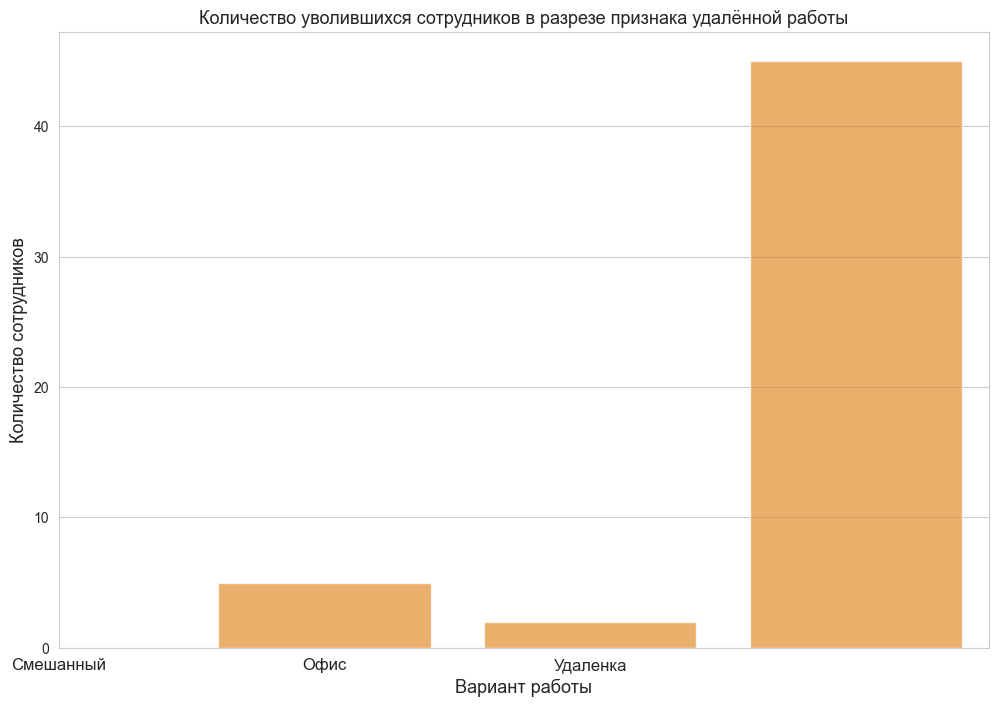

In [31]:
# График количества уволившихся сотрудников в разрезе признака удалённой работы
plt.figure(figsize=(12, 8))
sns.barplot(x='Вариант работы', y='Уволен', data=data, errorbar=None, estimator='sum', color='#FF8F0F', alpha=0.7)
plt.title('Количество уволившихся сотрудников в разрезе признака удалённой работы', fontsize=13)
plt.ylabel('Количество сотрудников', fontsize=13)
plt.xlabel('Вариант работы', fontsize=13)
plt.xticks([0, -1, 1], labels=['Офис', 'Смешанный', 'Удаленка'], fontsize=12)
plt.show()

Сотрудники, не посещающие офис, увольнялись чаще сотрудников, работающих в офисе, либо имеющих гибридный график работы.

## 4. Категориальные признаки

Варинат работы, пол - были закодированы сразу же в начале, чтобы участвовали в корреляциях.
Всякие отрицательные числа в полях, для которых подразумевается только положительная область определения, обычно кодируют какую то ситуацию, связанную с недостаточным количеством данных. 

## 5-6. Нормализация и разбиение на train-test.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [33]:
ml_columns = ['Сотрудник', 'Пол', 'Возраст', '1м Переработка', '2м Переработка', '3м Переработка', 'Вариант работы', 'Отработал месяцев',
        'Изменение должности (в месяцах)', 'Изменение оклада (в месяцах)', 'Количество отпусков (Основные отпуска)',
        'Количество дней (Основные отпуска)', 'Количество отпусков (Отпуска за свой счет)',
        'Количество дней (Отпуска за свой счет)', 'Факты обучения', 'Больничных дней', 'Средняя переработка за три месяца',
        '2-1 Отн. изменение активности (Отправленные письма)', '2-1 Отн. изменение активности (Отредактированные файлы)',
        '2-1 Отн. изменение активности (Время на работе)', '2-1 Отн. изменение активности (Активных дней)',
        '3-2 Отн. изменение активности (Отправленные письма)', '3-2 Отн. изменение активности (Отредактированные файлы)', 'Уволен']

ml_df = data.copy()[ml_columns]

ml_df.info()
ml_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 2543 entries, 0 to 2749
Data columns (total 24 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Сотрудник                                                2543 non-null   object 
 1   Пол                                                      2543 non-null   int64  
 2   Возраст                                                  2543 non-null   float64
 3   1м Переработка                                           2543 non-null   float64
 4   2м Переработка                                           2543 non-null   float64
 5   3м Переработка                                           2543 non-null   float64
 6   Вариант работы                                           2543 non-null   int64  
 7   Отработал месяцев                                        2543 non-null   float64
 8   Изменение должности (в месяцах)  

,Сотрудник,Пол,Возраст,1м Переработка,2м Переработка,3м Переработка,Вариант работы,Отработал месяцев,Изменение должности (в месяцах),Изменение оклада (в месяцах),Количество отпусков (Основные отпуска),Количество дней (Основные отпуска),Количество отпусков (Отпуска за свой счет),Количество дней (Отпуска за свой счет),Факты обучения,Больничных дней,Средняя переработка за три месяца,2-1 Отн. изменение активности (Отправленные письма),2-1 Отн. изменение активности (Отредактированные файлы),2-1 Отн. изменение активности (Время на работе),2-1 Отн. изменение активности (Активных дней),3-2 Отн. изменение активности (Отправленные письма),3-2 Отн. изменение активности (Отредактированные файлы),Уволен
0,6cb16d5872ddf3e6d66368f3bca42b250b5a403eb2814fc1b1c8c0bf1a0861b6,1,29.00,0.00,0.00,0.00,0,17.97,-1.00,17.97,1.00,7.00,0.00,0.00,0.00,0.00,0.00,0.88,-0.65,-0.03,-0.04,0.34,-1.00,0
1,b20d006cc40d753441ac14aa4d6e1b17ee04408c68467bcbd3e33d5ba4a29940,0,21.00,0.00,0.00,0.00,0,11.93,-1.00,-1.00,1.00,7.00,0.00,0.00,0.00,0.00,0.00,0.41,-0.56,0.29,0.13,-0.54,0.27,0
2,6362266aa19a113d3865682f4d710db06e8bbfaa2c6340878d0758428b196d2e,1,47.00,0.00,0.00,0.00,-1,9.60,2.67,2.13,2.00,6.00,3.00,3.00,0.00,0.00,0.00,-0.41,9.08,-1.00,-0.56,-0.02,-0.99,1
3,4a846608589e281e6d8cd362d2b555f5a23370aff0b7f0797c4d69e3a83d6099,1,38.00,0.00,0.00,0.00,0,78.43,10.17,2.13,1.00,5.00,3.00,3.00,0.00,8.00,0.00,-0.87,0.04,0.32,0.56,2.06,0.28,0
4,9eea0d4b6cf2177706b0d336b831ee70ecf12ec65e5f95dcde7d0c103022fe95,1,37.00,0.00,0.00,0.00,1,17.73,-1.00,9.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


Нормализованные данные любит kNN метод, потому что он непосредственно смотрит на расстояния между объектами. В нашем случае для лесов это не настолько обходимое явление. Хотя сотые к точности все-таки прибавляет.

In [34]:
#scaler = StandardScaler()

X = ml_df.drop(["Уволен", "Сотрудник"], axis=1)
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

y = ml_df["Уволен"]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

### 7-9. Обучение классификатора, тюниг параметров, оценка ошибок.

In [35]:
import xgboost as xgb
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [36]:
# XGBoost с гиперпараметрами по умолчанию
xgb_param = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'verbosity': 0,
    'random_state': 1,
}
model = xgb.XGBClassifier(**xgb_param)

# Определение гиперпараметров
param_dist = {
    'n_estimators': np.arange(460, 721, 10),
    'max_depth': np.arange(6, 9, 1),
    'learning_rate': np.arange(0.01, 0.05, 0.003),
    'alpha': np.arange(1.2, 2.2, 0.1),
    'lambda': np.arange(1.7, 2.9, 0.1),
    'subsample': np.arange(0.93, 1., 0.02),
    'colsample_bytree': np.arange(0.93, 1., 0.02),
    'min_child_weight': np.arange(1, 3, 1),
    'num_parallel_tree': np.arange(1, 3, 1),
}


# RandomizedSearchCV с кросс-валидацией
random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=4, n_iter=50, verbose=2, random_state=42, n_jobs=-1)

# Обучение RandomizedSearchCV на обучающих данных
random_search.fit(Xtrain, ytrain)

# Сохранение лучших гиперпараметров
xgb_params = random_search.best_params_
#print(xgb_params)

# Создаем и обучаем модель XGBoost с лучшими параметрами
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(Xtrain, ytrain)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


XGBClassifier(alpha=1.9000000000000006, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9700000000000001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.8, learning_rate=0.01,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=460, n_jobs=None, ...)

In [37]:
# Смотрим за качеством предикта на тестовых данных
score = xgb_model.predict(Xtest)
proba = xgb_model.predict_proba(Xtest)

f1 = f1_score(ytest, score)
print(f'f1-метрика = {f1:.5f}')

baccuracy = balanced_accuracy_score(ytest, score)
print(f'Сбалансированная точность = {baccuracy:.5f}')

f1-метрика = 0.00000
Сбалансированная точность = 0.50000


Получаем полный провал: из-за того, что на 2500 строчек приходится только 50 строчек класса уволенных, классификатор не может распознать этот класс... будем бороться с несбалансированностью

In [38]:
# Ячейка проверки предикта
predict = pd.DataFrame(data={'test': ytest, 'Predict': score, 'Proba': proba[:, 1]})
df = pd.merge(ml_df, predict[['Predict', 'Proba']], left_index=True, right_index=True)
df[df['Уволен'] != df['Predict']]

,Сотрудник,Пол,Возраст,1м Переработка,2м Переработка,3м Переработка,Вариант работы,Отработал месяцев,Изменение должности (в месяцах),Изменение оклада (в месяцах),Количество отпусков (Основные отпуска),Количество дней (Основные отпуска),Количество отпусков (Отпуска за свой счет),Количество дней (Отпуска за свой счет),Факты обучения,Больничных дней,Средняя переработка за три месяца,2-1 Отн. изменение активности (Отправленные письма),2-1 Отн. изменение активности (Отредактированные файлы),2-1 Отн. изменение активности (Время на работе),2-1 Отн. изменение активности (Активных дней),3-2 Отн. изменение активности (Отправленные письма),3-2 Отн. изменение активности (Отредактированные файлы),Уволен,Predict,Proba
25,4ec329922579e26523f470cdd54db321ce7d56810f194a5708f537f4255c4989,0,41.00,0.00,0.00,0.00,1,7.67,-1.00,4.47,2.00,10.00,2.00,2.00,0.00,7.00,0.00,-0.46,-2.00,0.00,-0.20,-0.59,6.14,1,0,0.20
49,c079c378cb9ce335b146979dd082b60b17d4f6177ef6e66f8ec2d6ddbe8b2646,0,35.00,0.87,0.00,0.00,-1,72.00,36.53,2.20,2.00,10.00,1.00,1.00,0.00,0.00,0.87,-0.03,0.42,-1.00,-0.12,-0.17,-0.32,1,0,0.01
178,b94aba5ed74e233c5ade095d667281090286b28bf33c907897d12c530122e54e,1,25.00,0.00,0.00,0.00,1,4.13,-1.00,4.13,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.50,-0.50,0.00,1,0,0.04
184,02d77424bf8c0a64b6460204c7786644daa612e1a5e970b9fbba9b87e28c9846,1,26.00,0.00,0.00,0.00,1,3.10,-1.00,3.10,1.00,7.00,3.00,3.00,0.00,7.00,0.00,0.56,-1.00,0.00,1.00,-0.31,-2.00,1,0,0.24
185,007e4ae5ff3e4f16364c6706a258819463a3434279b9f8c353b7fd9bded7622d,1,26.00,0.00,0.00,0.00,1,21.17,-1.00,15.13,3.00,17.00,0.00,0.00,0.00,0.00,0.00,-0.11,-2.00,0.00,0.14,0.19,2.95,1,0,0.06
261,c694c3414b8ac73b860ca21ca9e52c4334f9a798487f7e88128f67962f475f55,0,25.00,0.00,0.00,0.00,1,3.37,-1.00,3.37,0.00,0.00,3.00,4.00,0.00,15.00,0.00,-0.79,-2.00,0.00,-0.55,0.67,-0.90,1,0,0.05
435,f0367ad88d969f145764db665809432cbf669d45292a10cc94cbfd04e2a0487f,0,25.00,0.00,0.00,0.00,1,6.43,-1.00,0.93,0.00,0.00,1.00,1.00,0.00,0.00,0.00,-0.28,-1.00,0.00,0.19,-0.22,0.00,1,0,0.03
466,3e49ce4e7fdd29fd87608701e55c4561fdbe4b3b8934c102f0176e9537ddb090,1,25.00,0.00,0.00,0.00,1,10.83,-1.00,6.03,1.00,5.00,3.00,3.00,0.00,0.00,0.00,0.71,-2.00,0.00,0.17,-0.35,1.00,1,0,0.16
625,7622a8cbeb179d01f8946e6344b46fb4400ae1f974e92d87b08ca878bebee5c5,1,21.00,0.00,0.00,0.00,1,3.00,-1.00,3.00,0.00,0.00,5.00,5.00,0.00,0.00,0.00,-0.44,-1.00,0.00,0.12,1.94,-2.00,1,0,0.05
743,bb2be9aebd4b3873d08fe545699fdf2ee8e78e78db047ea8dd2f4384102699a3,1,27.00,0.00,0.00,0.00,1,26.93,-1.00,15.23,2.00,8.00,2.00,3.00,0.00,0.00,0.00,-0.16,0.00,0.00,0.25,0.25,0.00,1,0,0.14


In [39]:
# Важность признаков
fi = pd.DataFrame(data={'columns': Xtest.columns.tolist(), 'importance': xgb_model.feature_importances_})
fi.sort_values('importance', ascending=False)

,columns,importance
12,Количество дней (Отпуска за свой счет),0.20
5,Вариант работы,0.12
8,Изменение оклада (в месяцах),0.10
14,Больничных дней,0.07
9,Количество отпусков (Основные отпуска),0.07
17,2-1 Отн. изменение активности (Отредактированные файлы),0.07
20,3-2 Отн. изменение активности (Отправленные письма),0.06
10,Количество дней (Основные отпуска),0.05
6,Отработал месяцев,0.04
21,3-2 Отн. изменение активности (Отредактированные файлы),0.04


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

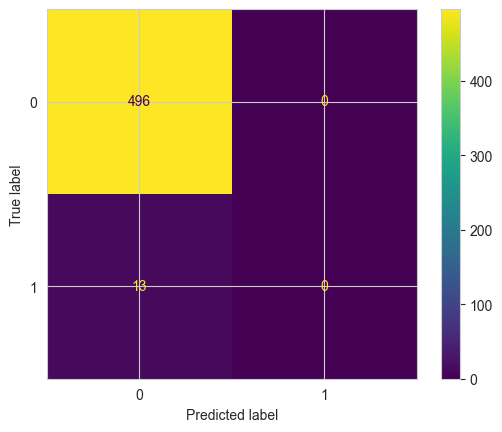

In [41]:
# Матрица ошибок
cm = confusion_matrix(ytest, score)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()

### 11. Несбалансированность классов

In [42]:
# Размножение класса уволенных    
duplicated_fired = ml_df.loc[np.repeat(ml_df[ml_df['Уволен'] == 1].index, 4)].reset_index(drop=True)
balanced_ml_df = pd.concat([ml_df, duplicated_fired], ignore_index=True).sample(frac=1)

In [43]:
#scaler = StandardScaler()

X = balanced_ml_df.drop(["Уволен", "Сотрудник"], axis=1)
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

y = balanced_ml_df["Уволен"]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost с гиперпараметрами по умолчанию
xgb_param = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'verbosity': 0,
    'random_state': 1,
}
model = xgb.XGBClassifier(**xgb_param)

# Определение гиперпараметров
param_dist = {
    'n_estimators': np.arange(460, 721, 10),
    'max_depth': np.arange(6, 9, 1),
    'learning_rate': np.arange(0.01, 0.05, 0.003),
    'alpha': np.arange(1.2, 2.2, 0.1),
    'lambda': np.arange(1.7, 2.9, 0.1),
    'subsample': np.arange(0.93, 1., 0.02),
    'colsample_bytree': np.arange(0.93, 1., 0.02),
    'min_child_weight': np.arange(1, 3, 1),
    'num_parallel_tree': np.arange(1, 3, 1),
}


# RandomizedSearchCV с кросс-валидацией
random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=4, n_iter=50, verbose=2, random_state=42, n_jobs=-1)

# Обучение RandomizedSearchCV на обучающих данных
random_search.fit(Xtrain, ytrain)

# Сохранение лучших гиперпараметров
xgb_params = random_search.best_params_
#print(xgb_params)

# Создаем и обучаем модель XGBoost с лучшими параметрами
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(Xtrain, ytrain)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


XGBClassifier(alpha=1.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.93, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.1000000000000005,
              learning_rate=0.03700000000000001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None, ...)

In [44]:
# Смотрим за качеством предикта на тестовых данных
score = xgb_model.predict(Xtest)
proba = xgb_model.predict_proba(Xtest)

f1 = f1_score(ytest, score)
print(f'f1-метрика = {f1:.5f}')

baccuracy = balanced_accuracy_score(ytest, score)
print(f'Сбалансированная точность = {baccuracy:.5f}')

f1-метрика = 0.97391
Сбалансированная точность = 0.99697


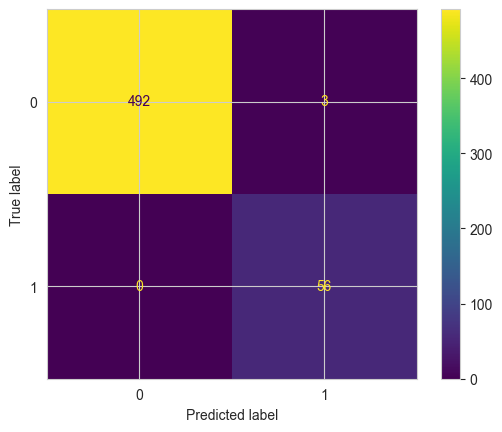

In [45]:
# Матрица ошибок
cm = confusion_matrix(ytest, score)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()

In [46]:
# Важность признаков
fi = pd.DataFrame(data={'columns': Xtest.columns.tolist(), 'importance': xgb_model.feature_importances_})
fi.sort_values('importance', ascending=False)

,columns,importance
5,Вариант работы,0.18
8,Изменение оклада (в месяцах),0.13
15,Средняя переработка за три месяца,0.09
12,Количество дней (Отпуска за свой счет),0.08
18,2-1 Отн. изменение активности (Время на работе),0.06
9,Количество отпусков (Основные отпуска),0.05
13,Факты обучения,0.04
14,Больничных дней,0.04
19,2-1 Отн. изменение активности (Активных дней),0.04
10,Количество дней (Основные отпуска),0.03


Побомбили из пушки, теперь можно посмотреть, насколько эта пушка лучше относительно самого простого kNN метода. Получается все наоборот.

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## Похоже, что ошибка в результате выполнения следующей ячейки является багом версии библиотеки.

У меня как раз 1.3.0 версия стоит. Поэтому с knn методом пока пролет, обновлю библиотеку, подстрою среду выполнения и добавлю изменения к этой работе.

https://github.com/scikit-learn/scikit-learn/issues/26768

In [48]:
knnC = KNeighborsClassifier()

grid = GridSearchCV(knnC, param_grid = {'n_neighbors': np.arange(2, 51, 2)}, cv=10)
grid.fit(Xtrain, ytrain)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

C:\Users\znaha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 246, in predict
    if self._fit_method == "brute" and ArgKminClassMode.is_usable_for(
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\metrics\_pairwise_distances_reduction\_dispatcher.

nan 2


C:\Users\znaha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 246, in predict
    if self._fit_method == "brute" and ArgKminClassMode.is_usable_for(
  File "C:\Users\znaha\anaconda3\lib\site-packages\sklearn\metrics\_pairwise_distances_reduction\_dispatcher.

In [ ]:
# Смотрим за качеством предикта на тестовых данных
score = knn_model.predict(Xtest)

f1 = f1_score(ytest, score)
print(f'f1-метрика = {f1:.5f}')

baccuracy = balanced_accuracy_score(ytest, score)
print(f'Сбалансированная точность = {baccuracy:.5f}')